**Workflow**. 
First I will store the all the data images into a npz format file and then use them for feature extraction.

In [ ]:
# mount the drive to load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now import all the requirements

Firstly we will preprocess the data and make it requirement matching with model. First resize all images (224, 224) and store into a numpy file along with thier labels to make it usable. This code will create a npz file which will contain all the images along with corresponding label.

In [ ]:
from os import listdir
from PIL import Image
from numpy import asarray
from os.path import isdir
from numpy import savez_compressed
from numpy import load

# Make a function 
def extract_image(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	array_img = asarray(image)
	# resize pixels to the model size
	image = Image.fromarray(array_img)
	image = image.resize(required_size)
	resized_array = asarray(image)
	return resized_array

# load images and resize for all images in a directory
def load_img_dir(directory):
 imgs = list()
 # enumerate files
 for filename in listdir(directory):
   path = directory + filename
   resized_img = extract_image(path)
   imgs.append(resized_img)
 return imgs

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		all_imgs = load_img_dir(path)
		# create labels
		labels = [subdir for _ in range(len(all_imgs))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(all_imgs), subdir))
		# store into array
		X.extend(all_imgs)
		y.extend(labels)
	return asarray(X), asarray(y)

Now give the path of directory which contains all images

In [ ]:
# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/Training Images/AIP_image/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/Training Images/AIP_image/test/')
# save arrays to one file in compressed format
savez_compressed('AIPcomplete_dataset11.npz', trainX, trainy, testX, testy)

>loaded 67 examples for class: duck
>loaded 82 examples for class: bear
>loaded 90 examples for class: camel
>loaded 111 examples for class: elephant
>loaded 92 examples for class: butterfly
>loaded 90 examples for class: chimp
(532, 224, 224, 3) (532,)
>loaded 20 examples for class: elephant
>loaded 20 examples for class: duck
>loaded 20 examples for class: chimp
>loaded 20 examples for class: camel
>loaded 20 examples for class: bear
>loaded 20 examples for class: butterfly


Our dataset npz file is ready. Now we need to split into training and testing

In [ ]:
# Load the dataset file
data = load('/content/drive/MyDrive/Training Images/AIPcomplete_dataset11 (1).npz')

# Segment it into train and test along with thier label
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded train and test set: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded train and test set:  (532, 224, 224, 3) (532,) (120, 224, 224, 3) (120,)


Now load the model remove the last layer and extract the features

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision import models
import torch
import torch.nn as nn
import numpy as np

In [ ]:
class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x
model_ft = models.resnet18(pretrained=True)
model_ft.fc = NullNet()

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model_ft = model_ft.to(device)

In [ ]:
# Models and transformations of the image into required format
def model_transform(model_ft , image):
  trf = T.Compose([T.ToPILImage(),
                  T.Resize(512),
                  T.CenterCrop(512),
                  T.ToTensor(), 
                  T.Normalize(mean = [0.485, 0.456, 0.406], 
                              std = [0.229, 0.224, 0.225])])
    

  input = trf(image).unsqueeze(0)
  #input = input.to(device)
  model_ft= model_ft.eval()
  output = model_ft(input)

  return output.detach().numpy()

In [ ]:
# Initialize two empty arrays to store output features
trainX_features = np.zeros((532,512))
trainy_features  = np.zeros((532,1))


In [ ]:
for i in range(0, 532):
  # feed image to model and store into array
  out = model_transform(model_ft, trainX[i,:,:,:])
  trainX_features[i,:] = out
  # And put the numeric values corresponding to labels
  if (trainy[i]=='duck'):
    trainy_features[i,:]= 0
  elif (trainy[i]=='bear'):
    trainy_features[i,:]= 1
  elif (trainy[i]=='camel'):
    trainy_features[i,:]=2
  elif (trainy[i]=='elephant'):
    trainy_features[i,:]=3
  elif (trainy[i]=='butterfly'):
    trainy_features[i,:]= 4
  elif (trainy[i]=='chimp'):
    trainy_features[i,:] = 5


[1.]


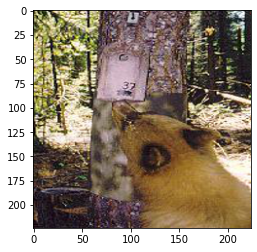

In [ ]:
# Now just test some random data point
n = np.random.randint(1, 532)
plt.imshow(trainX[n,:,:,:])
print(trainy_features[n])

In [ ]:
# Do same for test data
testX_features = np.zeros((120,512))
testy_features  = np.zeros((120,1))
for i in range(0, 120):
  out = model_transform(model_ft, testX[i,:,:,:])
  testX_features[i,:] = out
  if (testy[i]=='duck'):
    testy_features[i,:]= 0
  elif (testy[i]=='bear'):
    testy_features[i,:]= 1
  elif (testy[i]=='camel'):
    testy_features[i,:]=2
  elif (testy[i]=='elephant'):
    testy_features[i,:]=3
  elif (testy[i]=='butterfly'):
    testy_features[i,:]= 4
  elif (testy[i]=='chimp'):
    testy_features[i,:] = 5



Now our features extracted, and we need to evaluate accuaracy using KNN

In [ ]:
# import KNN model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
KNN_Model = KNeighborsClassifier(n_neighbors=3)

KNN_Model.fit(trainX_features, trainy_features)
predict_output = KNN_Model.predict(testX_features)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
#@title Default title text
# Print accuracy, precision, and recall
print('Accuracy of the model is :', accuracy_score(predict_output, testy_features))
print('Precision :', precision_score(testy_features, predict_output, average='macro'))
print('Recall :', recall_score(testy_features, predict_output, average='macro'))

Accuracy of the model is : 0.925
Precision : 0.935248778998779
Recall : 0.9250000000000002


So, Model accuracy, Precision, and recall on test dataset is 92.5%, 93.5%, and 92.5% Respectively